In [3]:
%matplotlib inline

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy

from ctisim import LogisticTrap, ITL_AMP_GEOM, SegmentSimulator, OutputAmplifier, LinearTrap
from ctisim.fitting import CTIModel, FixedLossModel, BiasDriftModel, SimulatedTrapModel
from ctisim.fitting import OverscanFitting

# ITL Full Deferred Charge Model

In [39]:
## Overscan results header
overscan_results = '../examples/data/ITL_overscan_results.fits'
hdul = fits.open(overscan_results)

prihdr = hdul[0].header
print(repr(prihdr), '\n')

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATASEC = '[4:512,1:2000]'                                                      
NAMPS   =                   16                                                  
CHECKSUM= 'NZoQQWoPNWoPNWoP'   / HDU checksum updated 2019-11-14T15:58:10       
DATASUM = '0       '           / data unit checksum updated 2019-11-14T15:58:10  



Text(0.5, 0, 'Signal [e-]')

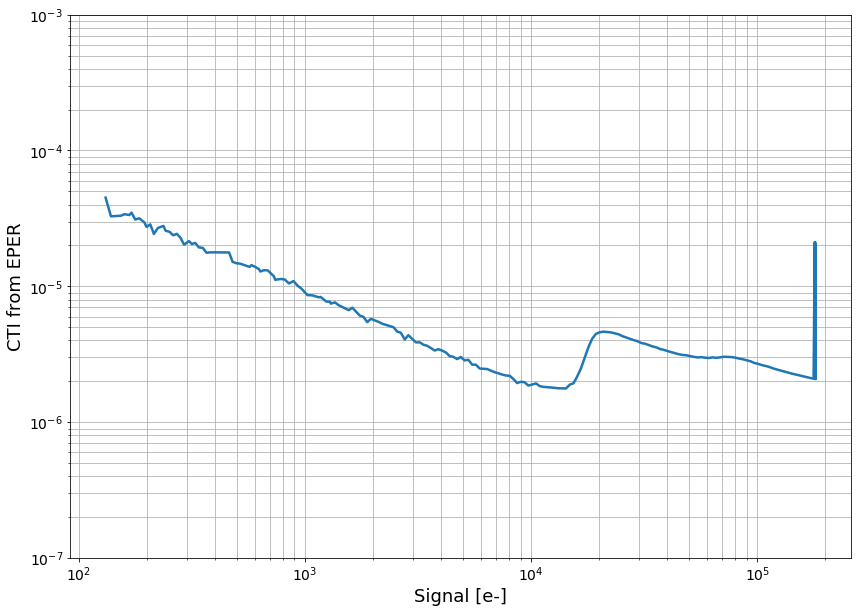

In [43]:
##CTI vs Signal for Data
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

amp = 7
data = hdul[amp].data
signal_all = data['FLUX']
indices = np.argsort(signal_all)
signal_data = signal_all[indices]

last_pix = data['MEANROW'][:, 511]
oscan1 = data['MEANROW'][:, 512]
#oscan2 = data['MEANROW'][:, 513]
oscan2 = 0
cti_data = ((oscan1+oscan2)/(512*last_pix))[indices]
      
ax.plot(signal_data, cti_data, linewidth=2.5)
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-3)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

In [63]:
## Low signal trapping
mcmc_results = fits.open('../examples/data/ITL_overscan_mcmc_results.fits')
mcmc_data = mcmc_results[1].data

print(repr(mcmc_results[1].header))

## Trap parameters
amp=7
cti = mcmc_data['CTI'][amp-1]
size = mcmc_data['TRAP_SIZE'][amp-1]
emission_time = mcmc_data['TRAP_TAU'][amp-1]
scaling = mcmc_data['TRAP_DFACTOR'][amp-1]
lowsignal_trap = LinearTrap(size, emission_time, 1, scaling, 0.0)
print(emission_time)

## Bias hysteresis parameters
drift_scale = mcmc_data['DRIFT_SIZE'][amp-1]
decay_time = mcmc_data['DRIFT_TAU'][amp-1]
threshold = mcmc_data['DRIFT_THRESHOLD'][amp-1]
output_amplifier = OutputAmplifier(1.0, 0.0, offset=0.0, drift_scale=drift_scale,
                                   decay_time=decay_time, threshold=threshold)


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   28 / length of dimension 1                          
NAXIS2  =                   16 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'CTI     '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'DRIFT_SIZE'                                                          
TFORM2  = 'E       '                                                            
TTYPE3  = 'DRIFT_TAU'       

Text(0.5, 0, 'Signal [e-]')

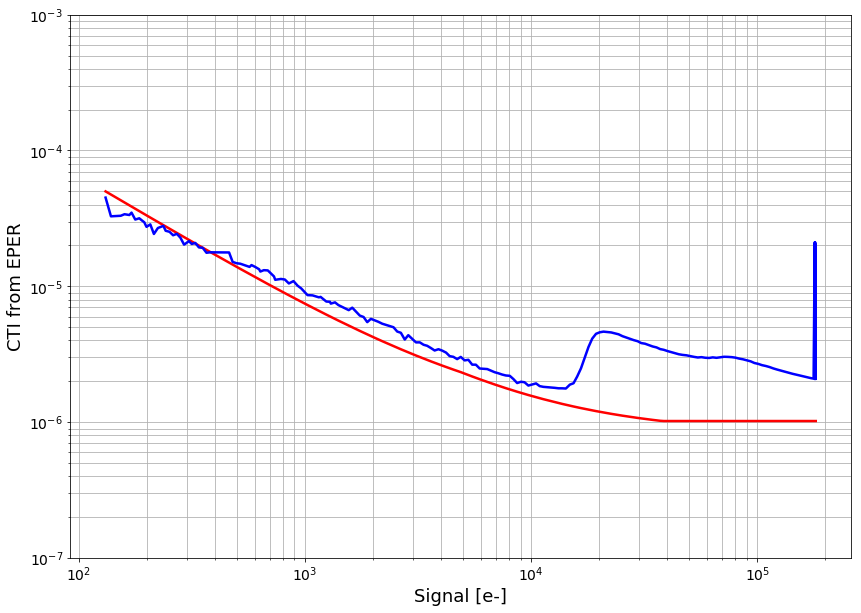

In [64]:
imarr = np.zeros((len(signal_data), ITL_AMP_GEOM.nx))
flat = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, cti=cti, traps=lowsignal_trap)
flat.ramp_exp(signal_data)

im = flat.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width, 
                           parallel_overscan_width=0,
                           do_bias_drift=False)

last_pix = im[:, 511]
oscan1 = im[:, 512]
cti_model = (oscan1/(512*last_pix))
      
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.plot(signal_data, cti_model, linewidth=2.5, color='red')
ax.plot(signal_data, cti_data, linewidth=2.5, color='blue')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-3)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

Text(0.5, 0, 'Signal [e-]')

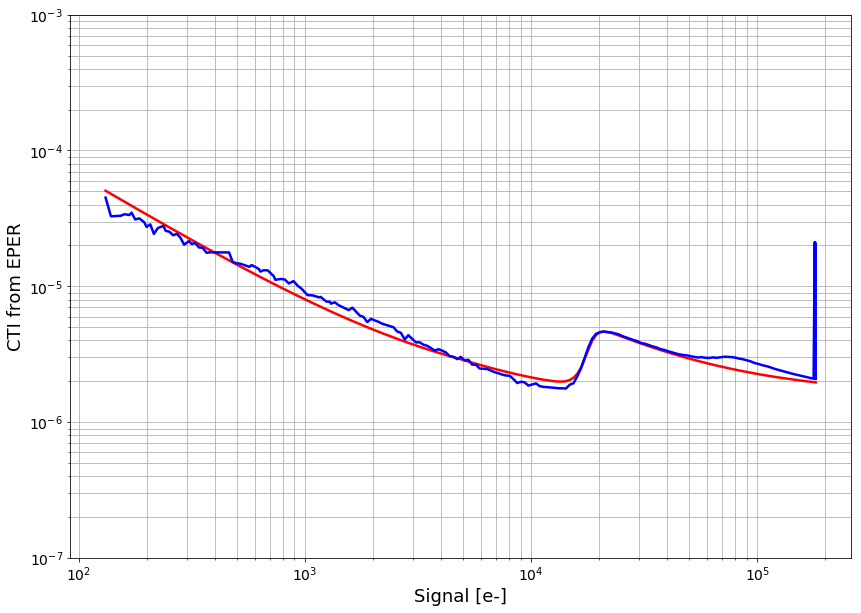

In [66]:
midsignal_trap = LogisticTrap(40, 0.5, 1, 18000., 0.0010)

imarr = np.zeros((len(signal_data), ITL_AMP_GEOM.nx))
flat = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, cti=cti, 
                        traps=[lowsignal_trap, midsignal_trap])
flat.ramp_exp(signal_data)


im = flat.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width, 
                           parallel_overscan_width=0,
                           do_bias_drift=True)

last_pix = im[:, 511]
oscan1 = im[:, 512]
cti_model = (oscan1)/(512*last_pix)
      
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.plot(signal_data, cti_model, linewidth=2.5, color='red')
ax.plot(signal_data, cti_data, linewidth=2.5, color='blue')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-3)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

# Testing Simple Overscan Models

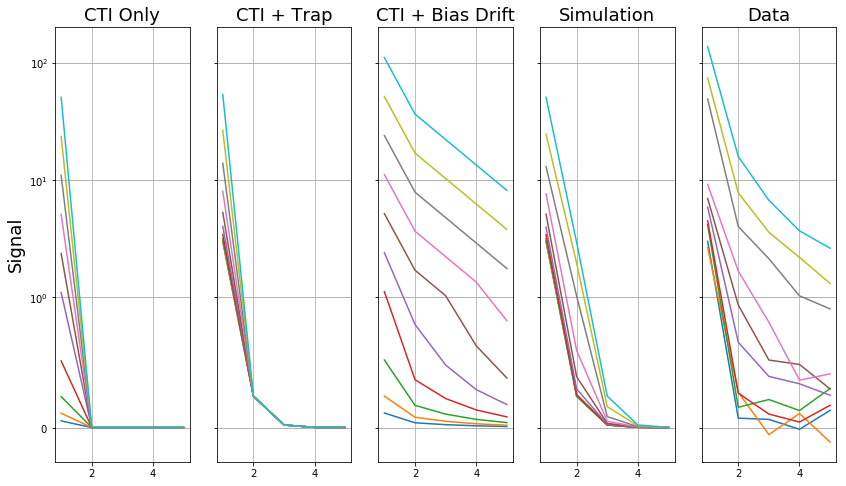

In [25]:
signals = np.logspace(2, 5, 10)
start = 1
stop = 5

## All model parameters
cti = 1.E-6
trapsize = 3.2
emission_time = 0.4
density_factor = 0.08
trap_threshold = 0.0

driftscale = 0.001
decay_time = 2.0
drift_threshold = 0.0

fig, axes = plt.subplots(1, 5, figsize=(14, 8), sharey=True)
axes = axes.flatten()

oscan_col = np.arange(start, stop+1)

## CTI only model
params = [cti]
model = CTIModel(params, 512)
r = model.results(signals, start=start, stop=stop)
for i, signal in enumerate(signals):
    axes[0].plot(oscan_col, r[i, :])
axes[0].set_ylabel('Signal', fontsize=18)
axes[0].set_title('CTI Only', fontsize=18)
axes[0].set_yscale('symlog', linthreshy=1.0)
axes[0].grid(True, which='both')
    
## Trap fixed loss model
params = [cti, trapsize, emission_time]
model = FixedLossModel(params, 512)
r = model.results(signals, start=start, stop=stop)
for i, signal in enumerate(signals):
    axes[1].plot(oscan_col, r[i, :])
axes[1].set_title('CTI + Trap', fontsize=18)
axes[1].set_yscale('symlog', linthreshy=1.0)
axes[1].grid(True, which='both')

    
## Bias drift proportional loss
params = [cti, driftscale, decay_time]
model = BiasDriftModel(params, 512)
r = model.results(signals, start=start, stop=stop)
for i, signal in enumerate(signals):
    axes[2].plot(oscan_col, r[i, :])
axes[2].set_title('CTI + Bias Drift', fontsize=18)
axes[2].set_yscale('symlog', linthreshy=1.0)
axes[2].grid(True, which='both')

## Simulation
params = [cti, trapsize, emission_time, density_factor, trap_threshold]
output_amplifier = OutputAmplifier(1.0, 0.0)
model = SimulatedTrapModel(params, ITL_AMP_GEOM, LinearTrap, output_amplifier)
r = model.results(signals, start=start, stop=stop)
for i, signal in enumerate(signals):
    axes[3].plot(oscan_col, r[i,:])         
axes[3].set_title('Simulation', fontsize=18)
axes[3].set_yscale('symlog', linthreshy=1.0)
axes[3].grid(True, which='both')

## Data
with fits.open('../examples/data/ITL_overscan_results.fits') as hdul:

    amp = 7
    hdu_data = hdul[amp].data
    signal_all = hdu_data['FLUX']
    oscan_data_all = hdu_data['MEANROW'][:, 511+start:512+stop]

    ## Filter out bad signal levels
    indices = signal_all < 140000.
    signal_good = signal_all[indices]
    oscan_data_good = oscan_data_all[indices]
    
for signal in signals:
    
    idx = min(range(signal_good.shape[0]), key=lambda i: abs(signal_good[i]-signal))
    axes[4].plot(oscan_col, oscan_data_good[idx,:])         
    axes[4].set_title('Data', fontsize=18)
    axes[4].set_yscale('symlog', linthreshy=1.0)
    axes[4].grid(True, which='both')
        

Text(0.5, 0, 'Signal [e-]')

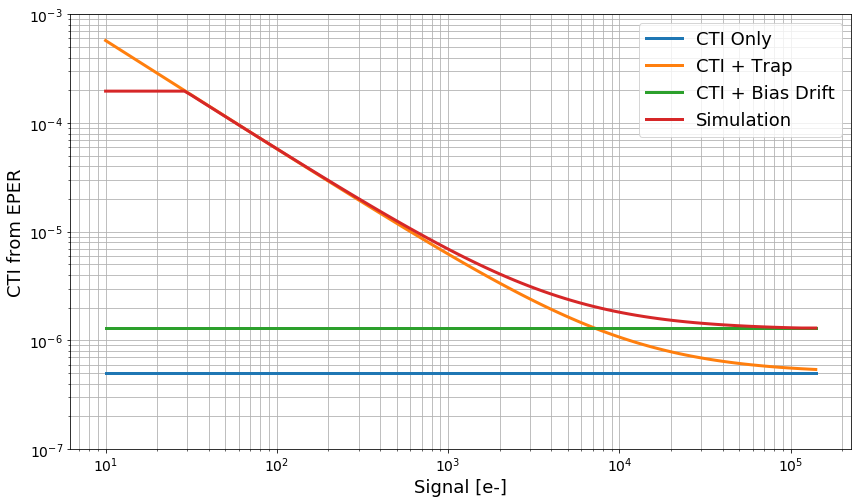

In [29]:
signals = np.logspace(1, np.log10(140000.), 100)
start = 1
stop = 5

fig, ax = plt.subplots(1, 1, figsize=(14, 8), sharey=True)

oscan_col = np.arange(start, stop+1)

## All model parameters
cti = 5.E-7
trapsize = 3.2
emission_time = 0.4
density_factor = 0.1
trap_threshold = 0.0

driftscale = 0.0008
decay_time = 1.5
drift_threshold = 0.0

## CTI only model
params = [cti]
model = CTIModel(params, 512)
r = model.results(signals, stop=stop)
cti_result = r[:, 0]/(signals*512)
ax.plot(signals, cti_result, linewidth=3, label='CTI Only')

## Trap fixed loss model
params = [cti, trapsize, emission_time]
model = FixedLossModel(params, 512)
r = model.results(signals, stop=stop)
cti_result = r[:, 0]/(signals*512)
ax.plot(signals, cti_result, linewidth=3, label='CTI + Trap')

## Bias drift proportional loss
params = [cti, driftscale, decay_time]
model = BiasDriftModel(params, 512)
r = model.results(signals, stop=stop)
cti_result = r[:, 0]/(signals*512)
ax.plot(signals, cti_result, linewidth=3, label='CTI + Bias Drift')

## Simulation
params = [cti, trapsize, emission_time, density_factor, trap_threshold]
output_amplifier = OutputAmplifier(1.0, 0.0, drift_scale=driftscale, decay_time=decay_time,
                                   threshold=drift_threshold)
model = SimulatedTrapModel(params, ITL_AMP_GEOM, LinearTrap, output_amplifier, do_bias_drift=True)
r = model.results(signals, stop=stop)
cti_result = r[:, 0]/(signals*512)
ax.plot(signals, cti_result, linewidth=3, label='Simulation')
    
ax.legend(fontsize=18)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-3)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

# Testing Overscan Fitting

In [11]:
## Get data for comparison
overscan_results = '../examples/data/ITL_overscan_results.fits'
hdul = fits.open(overscan_results)

amp = 7
hdu_data = hdul[amp].data
signal_all = hdu_data['FLUX']
oscan_data_all = hdu_data['MEANROW'][:, 512:]

## Filter out bad signal levels
indices = signal_all < 140000.
signal_good = signal_all[indices]
oscan_data_good = oscan_data_all[indices]

## CTI only model
params = [1.E-6]
constraints = [(1.E-7, 1.E-5)]
fitting_task = OverscanFitting(params, constraints, CTIModel, start=1, stop=oscan_data_all.shape[1])
loglikelihood = fitting_task.loglikelihood(params, signal_good, oscan_data_good, 6.5/np.sqrt(2000.), 512)
print(loglikelihood)

## Fixed loss model
params = [1.E-6, 4.0, 0.4]
constraints = [(1.E-7, 1.E-5), (0.0, 20.0), (0.01, 2.0)]
fitting_task = OverscanFitting(params, constraints, FixedLossModel, start=1, stop=oscan_data_all.shape[1])
loglikelihood = fitting_task.loglikelihood(params, signal_good, oscan_data_good, 6.5/np.sqrt(2000.), 512)
print(loglikelihood)

## Bias drift model
params = [1.E-6, 0.001, 1.5]
constraints = [(1.E-7, 1.E-5), (0.0, 0.01), (0.01, 4.0)]
fitting_task = OverscanFitting(params, constraints, BiasDriftModel, start=1, stop=oscan_data_all.shape[1])
loglikelihood = fitting_task.loglikelihood(params, signal_good, oscan_data_good, 6.5/np.sqrt(2000.), 512)
print(loglikelihood)

## Simulation Model
params = [1.E-6, 4.0, 0.4, 0.1, 0.01]
constraints = [(1.E-7, 1.E-5), (0.0, 20.0), (0.01, 2.0), (0.01, 1.0), (0.0, 10.0)]
output_amplifier = OutputAmplifier(1.0, 0.0, drift_scale=0.001, decay_time=1.5)
fitting_task = OverscanFitting(params, constraints, SimulatedTrapModel, start=1, stop=oscan_data_all.shape[1])
loglikelihood = fitting_task.loglikelihood(params, signal_good, oscan_data_good, 6.5/np.sqrt(2000.), 
                                           ITL_AMP_GEOM, LinearTrap, output_amplifier, do_bias_drift=True)
print(loglikelihood)

-4304912.961256882
-3799311.706894234
-1103985.7319887627
-1071004.429125446


## Fitting Bias Drift

[-7.          1.25887318  3.27618452]


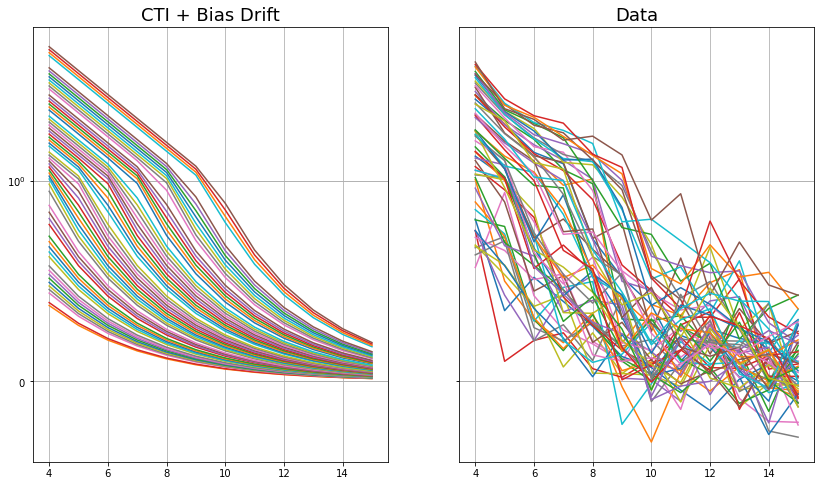

In [78]:
start = 4
stop = 15

## Data
with fits.open('../examples/data/ITL_overscan_results.fits') as hdul:

    amp = 2
    hdu_data = hdul[amp].data
    signal_all = hdu_data['FLUX']
    oscan_data_all = hdu_data['MEANROW'][:, 511+start:512+stop]

    ## Filter out bad signal levels
    indices = (signal_all < 140000.)*(signal_all > 20000.)
    signal_good = signal_all[indices]
    oscan_data_good = oscan_data_all[indices]

## Bias drift model
ctiexp = -7.0
driftscale = 2.0
decaytime = 2.0

params = [ctiexp, driftscale, decaytime]
constraints = [(-7, -7), (0.0, 10), (0.01, 4.0)]
fitting_task = OverscanFitting(params, constraints, BiasDriftModel, start=start, stop=stop)
fit_results = scipy.optimize.minimize(fitting_task.negative_loglikelihood, params, 
                                   args=(signal_good, oscan_data_good, 6.5/np.sqrt(2000.), 512),
                                   bounds=constraints, method='SLSQP')
print(fit_results.x)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
axes = axes.flatten()

oscan_col = np.arange(start, stop+1)

## Data
with fits.open('../examples/data/ITL_overscan_results.fits') as hdul:

    hdu_data = hdul[amp].data
    signal_all = hdu_data['FLUX']
    oscan_data_all = hdu_data['MEANROW'][:, 511+start:512+stop]

    ## Filter out bad signal levels
    indices = (signal_all < 150000.)*(signal_all > 10000.)
    signal_good = signal_all[indices]
    oscan_data_good = oscan_data_all[indices]
    
for i, signal in enumerate(signal_good):
    
    axes[1].plot(oscan_col, oscan_data_good[i,:])
    axes[1].set_title('Data', fontsize=18)
    axes[1].set_yscale('symlog', linthreshy=1.0)
    axes[1].grid(True, which='both')
    
## Bias drift proportional loss
params = [fit_results.x[0], fit_results.x[1], fit_results.x[2]]
model = BiasDriftModel(params, 512)

r = model.results(signal_good, start=start, stop=stop)
for i, signal in enumerate(signal_good):
    axes[0].plot(oscan_col, r[i, :])
axes[0].set_title('CTI + Bias Drift', fontsize=18)
axes[0].set_yscale('symlog', linthreshy=1.0)
axes[0].grid(True, which='both')

Text(0.5, 0, 'Signal [e-]')

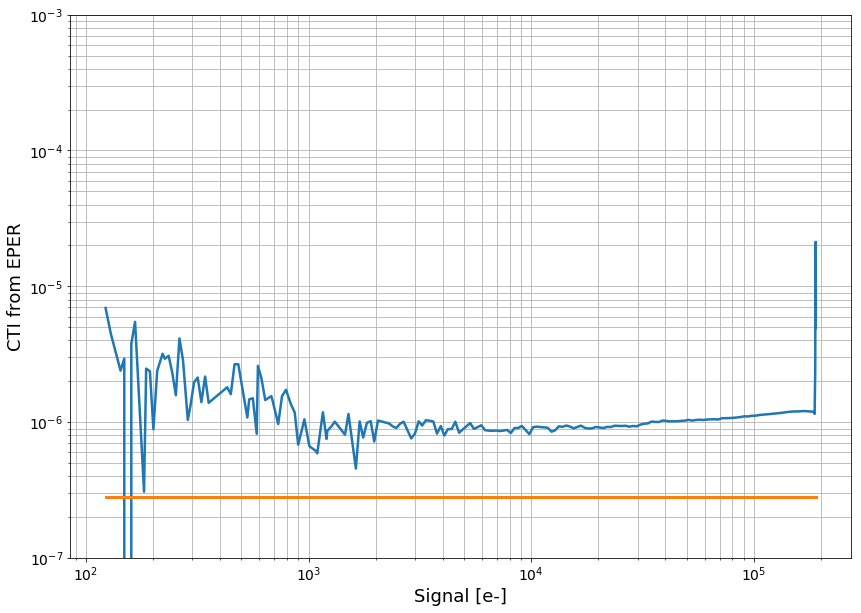

In [79]:
##CTI vs Signal for Data
fig, ax = plt.subplots(1, 1, figsize=(14, 10))


with fits.open('../examples/data/ITL_overscan_results.fits') as hdul:

    hdu_data = hdul[amp].data
    data = hdul[amp].data
    signal_all = data['FLUX']
    indices = np.argsort(signal_all)
    signal_data = signal_all[indices]

    last_pix = data['MEANROW'][:, 511]
    oscan1 = data['MEANROW'][:, 512]
    cti_result = ((oscan1)/(512*last_pix))[indices]      
    ax.plot(signal_data, cti_result, linewidth=2.5)

## Bias drift proportional loss
params = [fit_results.x[0], fit_results.x[1], fit_results.x[2]]
model = BiasDriftModel(params, 512)
r = model.results(signal_data, stop=stop)
cti_result = r[:, 0]/(signal_data*512)
ax.plot(signal_data, cti_result, linewidth=3, label='CTI + Bias Drift')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-3)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

[-6.          1.25887318  3.27618452]


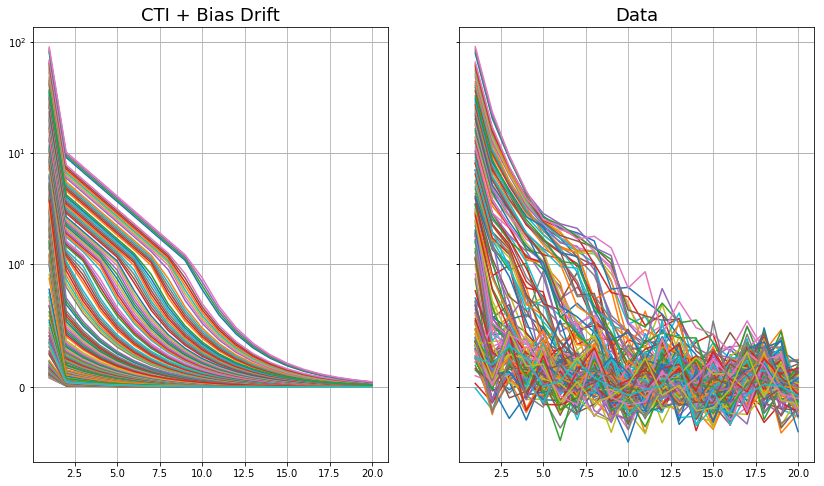

In [80]:
start = 1
stop = 2

## Data
with fits.open('../examples/data/ITL_overscan_results.fits') as hdul:

    amp = 2
    hdu_data = hdul[amp].data
    signal_all = hdu_data['FLUX']
    oscan_data_all = hdu_data['MEANROW'][:, 511+start:512+stop]

    ## Filter out bad signal levels
    indices = (signal_all < 150000.)
    signal_good = signal_all[indices]
    oscan_data_good = oscan_data_all[indices]

## Bias drift model
params = [-6, fit_results.x[1], fit_results.x[2]]
constraints = [(-6.7, -5.8), (fit_results.x[1], fit_results.x[1]), (fit_results.x[2], fit_results.x[2])]
fitting_task = OverscanFitting(params, constraints, BiasDriftModel, start=start, stop=stop)
fit_results = scipy.optimize.minimize(fitting_task.negative_loglikelihood, params, 
                                   args=(signal_good, oscan_data_good, 6.5/np.sqrt(2000.), 512),
                                   bounds=constraints, method='SLSQP')
print(fit_results.x)

start = 1
stop = 20
fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
axes = axes.flatten()

oscan_col = np.arange(start, stop+1)

## Data
with fits.open('../examples/data/ITL_overscan_results.fits') as hdul:

    hdu_data = hdul[amp].data
    signal_all = hdu_data['FLUX']
    oscan_data_all = hdu_data['MEANROW'][:, 511+start:512+stop]

    ## Filter out bad signal levels
    indices = (signal_all < 150000.)    
    signal_good = signal_all[indices]
    oscan_data_good = oscan_data_all[indices]
    
for i, signal in enumerate(signal_good):
    
    axes[1].plot(oscan_col, oscan_data_good[i,:])         
    axes[1].set_title('Data', fontsize=18)
    axes[1].set_yscale('symlog', linthreshy=1.0)
    axes[1].grid(True, which='both')
    
## Bias drift proportional loss
params = [fit_results.x[0], fit_results.x[1], fit_results.x[2]]
model = BiasDriftModel(params, 512)

r = model.results(signal_good, start=start, stop=stop)
for i, signal in enumerate(signal_good):
    axes[0].plot(oscan_col, r[i, :])
axes[0].set_title('CTI + Bias Drift', fontsize=18)
axes[0].set_yscale('symlog', linthreshy=1.0)
axes[0].grid(True, which='both')

[-6.0, 1.2588731783567333, 3.2761845204128357]


Text(0.5, 0, 'Signal [e-]')

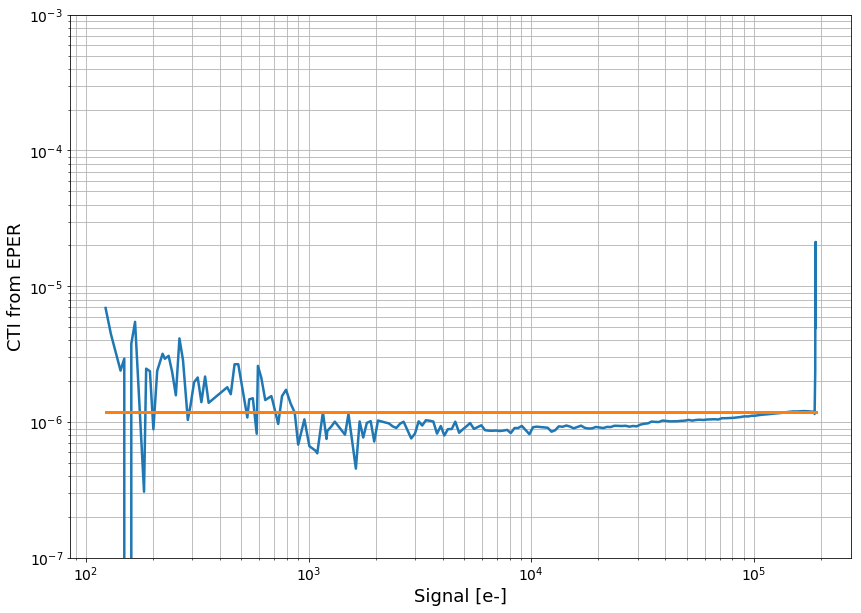

In [81]:
##CTI vs Signal for Data
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

with fits.open('../examples/data/ITL_overscan_results.fits') as hdul:

    hdu_data = hdul[amp].data
    data = hdul[amp].data
    signal_all = data['FLUX']
    indices = np.argsort(signal_all)
    signal_data = signal_all[indices]

    last_pix = data['MEANROW'][:, 511]
    oscan1 = data['MEANROW'][:, 512]
    cti_result = ((oscan1)/(512*last_pix))[indices]      
    ax.plot(signal_data, cti_result, linewidth=2.5)

## Bias drift proportional loss
params = [fit_results.x[0], fit_results.x[1], fit_results.x[2]]
print(params)
model = BiasDriftModel(params, 512)
r = model.results(signal_data, stop=stop)
cti_result = r[:, 0]/(signal_data*512)
ax.plot(signal_data, cti_result, linewidth=3, label='CTI + Bias Drift')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-3)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

[-6.19        2.76492448  2.16506223]


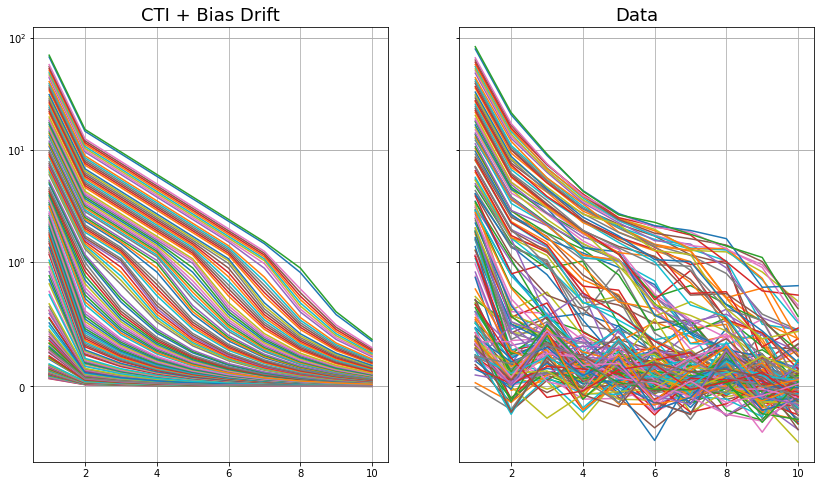

In [82]:
start = 1
stop = 10

## Data
with fits.open('../examples/data/ITL_overscan_results.fits') as hdul:

    amp = 2
    hdu_data = hdul[amp].data
    signal_all = hdu_data['FLUX']
    oscan_data_all = hdu_data['MEANROW'][:, 511+start:512+stop]

    ## Filter out bad signal levels
    indices = (signal_all < 140000.)
    signal_good = signal_all[indices]
    oscan_data_good = oscan_data_all[indices]

## Bias drift model
ctiexp = -6.1
driftscale = 2.0
decaytime = 2.0

params = [ctiexp, driftscale, decaytime]
constraints = [(-7, -5.8), (0.0, 10), (0.01, 4.0)]
fitting_task = OverscanFitting(params, constraints, BiasDriftModel, start=start, stop=stop)
fit_results = scipy.optimize.minimize(fitting_task.negative_loglikelihood, params, 
                                   args=(signal_good, oscan_data_good, 6.5/np.sqrt(2000.), 512),
                                   bounds=constraints, method='SLSQP')
print(fit_results.x)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
axes = axes.flatten()

oscan_col = np.arange(start, stop+1)

## Data
with fits.open('../examples/data/ITL_overscan_results.fits') as hdul:

    hdu_data = hdul[amp].data
    signal_all = hdu_data['FLUX']
    oscan_data_all = hdu_data['MEANROW'][:, 511+start:512+stop]

    ## Filter out bad signal levels
    indices = (signal_all < 140000.)
    signal_good = signal_all[indices]
    oscan_data_good = oscan_data_all[indices]
    
for i, signal in enumerate(signal_good):
    
    axes[1].plot(oscan_col, oscan_data_good[i,:])         
    axes[1].set_title('Data', fontsize=18)
    axes[1].set_yscale('symlog', linthreshy=1.0)
    axes[1].grid(True, which='both')
    
## Bias drift proportional loss
params = [fit_results.x[0], fit_results.x[1], fit_results.x[2]]
model = BiasDriftModel(params, 512)

r = model.results(signal_good, start=start, stop=stop)
for i, signal in enumerate(signal_good):
    axes[0].plot(oscan_col, r[i, :])
axes[0].set_title('CTI + Bias Drift', fontsize=18)
axes[0].set_yscale('symlog', linthreshy=1.0)
axes[0].grid(True, which='both')